


## Task 2: Symbolic Conditioned Generation (Harmonization) ##
## Yifan Fu, Jack Lund

This notebook implements a deep learning system for four-part choir harmonization. Given a melody line and chord progression, our system generates appropriate soprano, alto, tenor, and bass voice parts.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from math import pi

# Music processing
try:
    from music21 import stream, note, chord, meter, key, tempo, duration, converter
    MUSIC21_AVAILABLE = True
    print(" Music21 available")
except ImportError:
    MUSIC21_AVAILABLE = False
    print(" Music21 not available")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(" All libraries imported successfully")

 Music21 available
 All libraries imported successfully


In [2]:
# 
# Config and parameter for our project
# 
class Config:
    # input data
    XML_FOLDER = "input/dataset1"     # xml files
    RAW_JSON = "input/rawdata.json"   # xml to json
    
    # model and vocab
    BASELINE_MODEL_PATH = "models/baseline_model.pth"
    BASELINE_VOCAB_PATH = "models/baseline_vocab.pkl"

    IMPROVED_MODEL_PATH = "models/improved_model.pth"
    IMPROVED_VOCAB_PATH = "models/improved_vocab.pkl"
    
    # ouput files
    MIDI_OUTPUT_DIR = "outputs/generated_chorales"   # mid file for listening
    EVAL_OUTPUT_DIR = "outputs/evaluation_results"   # save plot graphs

    
    # parameters for adjusting    
    BATCH_SIZE = 32   #64
    LEARNING_RATE = 0.0005  # 0.0001
    EPOCHS = 100
    MAX_LENGTH = 128
    HIDDEN_DIM = 256
    NUM_LAYERS = 2

    WEIGHT_DECAY = 1e-5  
    GRAD_CLIP = 1.0  
    WARMUP_STEPS = 1000  
    
    # data split
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

## 1. Data Collection and Preprocessing

### Dataset Description
Our dataset consists of classical music compositions in MusicXML format. These files contain:
- Individual voice parts (Soprano, Alto, Tenor, Bass)
- Melodic lines and harmonic progressions
- Timing and key signature information

### Processing Pipeline
1. **XML Parsing**: Extract musical elements from MusicXML files
2. **Voice Extraction**: Separate four choir parts
3. **Chord Analysis**: Generate harmonic progressions
4. **Validation**: Ensure data quality and consistency
5. **Serialization**: Convert to JSON for efficient loading

In [3]:
#
#  XML process
#
# Extract note names from a musical part
# Handles both single notes and chords by getting root note or first pitch.
# Returns a list of note names with octave information
def extract_notes_from_part(part):
    notes = []
    for elem in part.flat.notes:
        if isinstance(elem, note.Note):
            notes.append(elem.nameWithOctave)
        elif isinstance(elem, chord.Chord):
            root = elem.root()
            notes.append(root.nameWithOctave if root else elem.pitches[0].nameWithOctave)
    return notes

# Extract chord information measure by measure
# Convert score to chordified version and analyze chord roots by measure
# Used to provide harmonic context for conditioned generation
def extract_chords_measurewise(score):
    chords = []
    try:
        chordified = score.chordify()
        measures = chordified.getElementsByClass('Measure')
        for m in measures:
            chords_in_measure = m.recurse().getElementsByClass('Chord')
            if chords_in_measure:
                root = chords_in_measure[0].root()
                chords.append(root.name if root else chords_in_measure[0].pitches[0].name)
            else:
                notes_in_measure = m.recurse().getElementsByClass('Note')
                if notes_in_measure:
                    chords.append(notes_in_measure[0].name)
                else:
                    chords.append("N")
    except:
        chords = ["N"] * 10
    return chords

# Extract four voice parts (soprano, alto, tenor, bass) from a musical score
# Ensures exactly 4 voices are returned, filling with empty lists if needed
# Returns tuple of (soprano, alto, tenor, bass) note sequences
def extract_voices(score):
    parts = score.parts
    voices = []
    for i in range(4):
        if i < len(parts):
            voices.append(extract_notes_from_part(parts[i]))
        else:
            voices.append([])
    return voices[0], voices[1], voices[2], voices[3]

# Process a single XML music file and extract voice data
def process_xml_file(file_path):
    try:
        score = converter.parse(file_path)
        soprano, alto, tenor, bass = extract_voices(score)
        melody = soprano if soprano else extract_notes_from_part(score)
        chords = extract_chords_measurewise(score)
        
        all_sequences = [melody, chords, soprano, alto, tenor, bass]
        non_empty_sequences = [seq for seq in all_sequences if len(seq) > 0]
        
        if not non_empty_sequences:
            return None
        
        min_length = min(len(seq) for seq in non_empty_sequences)
        if min_length < 4:
            return None
        
        return {
            "filename": os.path.basename(file_path),
            "melody": melody[:min_length] if melody else ["N"] * min_length,
            "chords": chords[:min_length] if chords else ["N"] * min_length,
            "targets": {
                "soprano": soprano[:min_length] if soprano else ["N"] * min_length,
                "alto": alto[:min_length] if alto else ["N"] * min_length,
                "tenor": tenor[:min_length] if tenor else ["N"] * min_length,
                "bass": bass[:min_length] if bass else ["N"] * min_length
            }
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Convert all XML music files in the input folder to a single JSON file
def convert_xml_to_json():
    print("Converting XML files to JSON...")
    folder_path = Path(Config.XML_FOLDER)
    if not folder_path.exists():
        print(f"Error: {Config.XML_FOLDER} not found")
        return False
    
    xml_files = []
    for ext in ['*.xml', '*.musicxml', '*.mxl']:
        xml_files.extend(folder_path.glob(ext))
    
    if not xml_files:
        print(f"No XML files found in {Config.XML_FOLDER}")
        return False
    
    data = []
    for xml_file in xml_files:
        sample = process_xml_file(xml_file)
        if sample:
            data.append(sample)
    
    if data:
        os.makedirs(os.path.dirname(Config.RAW_JSON), exist_ok=True)
        with open(Config.RAW_JSON, "w", encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f"Converted {len(data)} files to {Config.RAW_JSON}")
        return True
    return False

# create the folders if user don't have them
def create_folders():
    folders = [Config.MIDI_OUTPUT_DIR, Config.EVAL_OUTPUT_DIR,
               os.path.dirname(Config.IMPROVED_VOCAB_PATH),os.path.dirname(Config.BASELINE_VOCAB_PATH), os.path.dirname(Config.RAW_JSON)]
    for folder in folders:
        Path(folder).mkdir(parents=True, exist_ok=True)

# load and split data for training/validating/testing 
# return the ratioof the split
def load_and_split_data():
    with open(Config.RAW_JSON, 'r') as f:
        data = json.load(f)
    
    if isinstance(data, dict):
        data = data.get('train', data.get('data', list(data.values())[0]))
    
    train_size = int(0.7 * len(data))
    val_size = int(0.15 * len(data))
    
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    
    return train_data, val_data, test_data


   Loaded 366 samples from dataset
   Sequence length statistics:
   Mean: 17.0
   Median: 16.0
   Min: 7, Max: 67


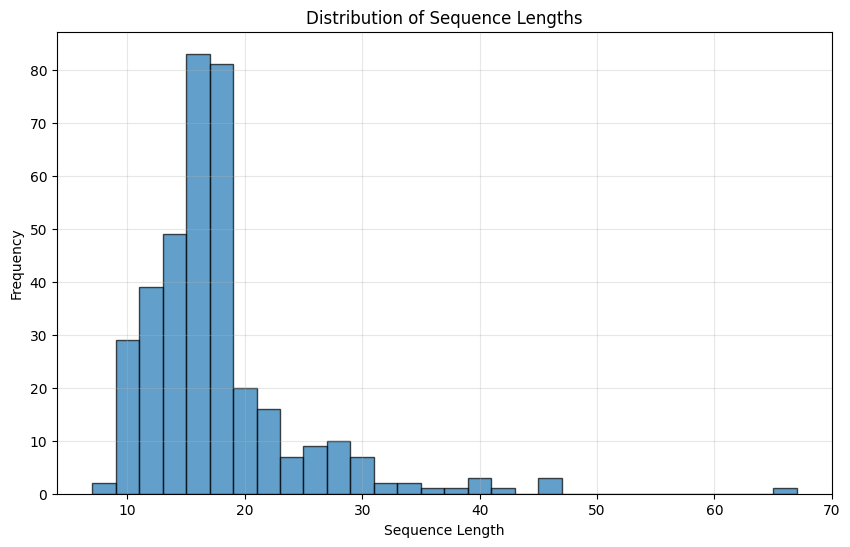

In [4]:
# Load and analyze the dataset
try:
    with open(Config.RAW_JSON, 'r') as f:
        raw_data = json.load(f)
    print(f"   Loaded {len(raw_data)} samples from dataset")
    
    # Analyze data characteristics
    melody_lengths = [len(sample['melody']) for sample in raw_data]
    
    print(f"   Sequence length statistics:")
    print(f"   Mean: {np.mean(melody_lengths):.1f}")
    print(f"   Median: {np.median(melody_lengths):.1f}")
    print(f"   Min: {min(melody_lengths)}, Max: {max(melody_lengths)}")
    
    # Plot sequence length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(melody_lengths, bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()  
except FileNotFoundError:
    print(" Dataset not found ")

## 2. Model Architecture

### Problem Formulation
- **Input**: Melody sequence + Chord progression
- **Output**: Four voice parts (Soprano, Alto, Tenor, Bass)
- **Approach**: Encoder-decoder with multi-head output

### Architecture Design

In [5]:
#
#  Models
#
# Deep four-part choir model 
class DeepChoirModel(nn.Module):
    def __init__(self, note_vocab_size, chord_vocab_size, hidden_dim=256, num_layers=2):
        super(DeepChoirModel, self).__init__()
        self.note_embed = nn.Embedding(note_vocab_size, hidden_dim)
        self.chord_embed = nn.Embedding(chord_vocab_size, hidden_dim)
        self.encoder = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers, batch_first=True)
        self.decoders = nn.ModuleDict({
            voice: nn.Sequential(
                nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True),
                nn.Linear(hidden_dim, note_vocab_size)
            ) for voice in ['soprano', 'alto', 'tenor', 'bass']
        })
    
    def forward(self, melody, chords):
        melody_embed = self.note_embed(melody)
        chords_embed = self.chord_embed(chords)
        combined = torch.cat([melody_embed, chords_embed], dim=-1)
        enc_out, _ = self.encoder(combined)
        
        outputs = {}
        for voice, decoder in self.decoders.items():
            dec_out, _ = decoder[0](enc_out)
            logits = decoder[1](dec_out)
            outputs[voice] = logits
        return outputs

In [6]:
# Vocabulary builder for creating note-to-index mappings
# exp:  origin from input data   ->  C4  →  D4  →  E4  →  F4  →  G4
#       data be saved into vacab ->   4  →   5  →   6  →   7  →   8   
class VocabBuilder:
    def __init__(self):
        self.note_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.chord_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_note = {0: '<PAD>', 1: '<UNK>'}
        self.idx_to_chord = {0: '<PAD>', 1: '<UNK>'}
    
    def build_vocab(self, data):
        note_counter = Counter()
        chord_counter = Counter()
        
        for sample in data:
            for note in sample['melody']:
                note_counter[note] += 1
            for voice_notes in sample['targets'].values():
                for note in voice_notes:
                    note_counter[note] += 1
            for chord in sample['chords']:
                chord_counter[chord] += 1
        
        for note, count in note_counter.items():
            if count > 1 and note not in self.note_to_idx:
                idx = len(self.note_to_idx)
                self.note_to_idx[note] = idx
                self.idx_to_note[idx] = note
        
        for chord, count in chord_counter.items():
            if count > 0 and chord not in self.chord_to_idx:
                idx = len(self.chord_to_idx)
                self.chord_to_idx[chord] = idx
                self.idx_to_chord[idx] = chord
    
    def encode_sequence(self, sequence, vocab_dict):
        return [vocab_dict.get(item, vocab_dict['<UNK>']) for item in sequence]
    
    def save_vocab(self, path):
        vocab_data = {
            'note_to_idx': self.note_to_idx,
            'chord_to_idx': self.chord_to_idx,
            'idx_to_note': self.idx_to_note,
            'idx_to_chord': self.idx_to_chord
        }
        with open(path, 'wb') as f:
            pickle.dump(vocab_data, f)

# #  Choir dataset class for PyTorch training
class ChoirDataset(Dataset):
    def __init__(self, data, vocab_builder, max_length=128):
        self.data = data
        self.vocab = vocab_builder
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        melody = self.vocab.encode_sequence(sample['melody'], self.vocab.note_to_idx)
        chords = self.vocab.encode_sequence(sample['chords'], self.vocab.chord_to_idx)
        
        voices = {}
        for voice_name, voice_data in sample['targets'].items():
            voices[voice_name] = self.vocab.encode_sequence(voice_data, self.vocab.note_to_idx)
        
        seq_len = min(len(melody), self.max_length)
        melody = melody[:seq_len] + [0] * (self.max_length - seq_len)
        chords = chords[:seq_len] + [0] * (self.max_length - seq_len)
        
        for voice_name in voices:
            voice_seq = voices[voice_name][:seq_len] + [0] * (self.max_length - seq_len)
            voices[voice_name] = voice_seq
        
        return {
            'melody': torch.tensor(melody, dtype=torch.long),
            'chords': torch.tensor(chords, dtype=torch.long),
            'targets': {voice: torch.tensor(seq, dtype=torch.long) 
                       for voice, seq in voices.items()},
            'length': seq_len
        }

# Batch data collation 
def collate_fn(batch):
    melody = torch.stack([item['melody'] for item in batch])
    chords = torch.stack([item['chords'] for item in batch])
    targets = {}
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        targets[voice] = torch.stack([item['targets'][voice] for item in batch])
    lengths = torch.tensor([item['length'] for item in batch])
    return {'melody': melody, 'chords': chords, 'targets': targets, 'lengths': lengths}

# count how many parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Main training function
- **baseline**
- **improved**

In [7]:
# Compute basic cross-entropy loss
def compute_basic_loss(outputs, targets, lengths, criterion):
    """Standard cross entropy loss for baseline model"""
    total_loss = 0
    voice_weights = {'soprano': 1.0, 'alto': 1.0, 'tenor': 1.0, 'bass': 1.2}
    
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        pred = outputs[voice].view(-1, outputs[voice].size(-1))
        target = targets[voice].view(-1)
        
        # Create mask for valid positions
        mask = torch.zeros_like(target, dtype=torch.bool)
        for i, length in enumerate(lengths):
            mask[i * outputs[voice].size(1):(i * outputs[voice].size(1) + length)] = True
        
        pred_masked = pred[mask]
        target_masked = target[mask]
        
        if len(target_masked) > 0:
            voice_loss = criterion(pred_masked, target_masked)
            total_loss += voice_weights[voice] * voice_loss
    
    return total_loss / len(voice_weights)

# Compute music theory constraint loss -- Apply constraints based on voice spacing and music theory rules
def compute_music_constraint_loss(outputs, targets, lengths, vocab_builder):
    """Music theory constraint loss - encourage better harmonic progressions"""
    device = outputs['soprano'].device
    constraint_loss = 0
    
    # Voice spacing constraints
    for i in range(len(lengths)):
        length = lengths[i]
        
        for t in range(1, length):  # Start from second time step
            # Get prediction probabilities for each voice
            soprano_probs = torch.softmax(outputs['soprano'][i, t], dim=-1)
            alto_probs = torch.softmax(outputs['alto'][i, t], dim=-1)
            tenor_probs = torch.softmax(outputs['tenor'][i, t], dim=-1)
            bass_probs = torch.softmax(outputs['bass'][i, t], dim=-1)
            
            # Simple voice spacing constraint - encourage reasonable intervals
            # This is a simplified version, can be more complex in practice
            interval_penalty = compute_interval_penalty(
                soprano_probs, alto_probs, tenor_probs, bass_probs, vocab_builder
            )
            constraint_loss += interval_penalty
    
    return constraint_loss / (len(lengths) * max(1, torch.mean(lengths.float()).item()))

# Compute voice spacing penalty  -- Avoid voices being too close by calculating probability distribution similarities
def compute_interval_penalty(soprano_probs, alto_probs, tenor_probs, bass_probs, vocab_builder):
    """Calculate interval constraint penalty (simplified version)"""
    # Simplified interval constraint implementation
    # In real projects, more complex constraints based on music theory can be added
    
    # Encourage different notes in different voices (avoid excessive repetition)
    # Calculate similarity between voices, penalize excessive similarity
    
    similarities = []
    probs_list = [soprano_probs, alto_probs, tenor_probs, bass_probs]
    
    for i in range(len(probs_list)):
        for j in range(i+1, len(probs_list)):
            # Calculate probability distribution similarity (simplified KL divergence)
            similarity = torch.sum(probs_list[i] * probs_list[j])
            similarities.append(similarity)
    
    # Penalize overly similar voices
    avg_similarity = torch.mean(torch.stack(similarities))
    penalty = torch.relu(avg_similarity - 0.3)  # Penalize if similarity exceeds 0.3
    
    return penalty

# Compute musical coherence loss
def compute_coherence_loss(outputs, lengths):
    """Coherence loss - encourage smooth voice leading"""
    coherence_loss = 0
    
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        voice_output = outputs[voice]
        
        for i in range(len(lengths)):
            length = lengths[i]
            if length <= 1:
                continue
            
            # Calculate smoothness of adjacent time step predictions
            for t in range(length - 1):
                current_probs = torch.softmax(voice_output[i, t], dim=-1)
                next_probs = torch.softmax(voice_output[i, t+1], dim=-1)
                
                # Calculate KL divergence between adjacent time step probability distributions
                kl_div = torch.sum(current_probs * torch.log(current_probs / (next_probs + 1e-8) + 1e-8))
                coherence_loss += kl_div
    
    return coherence_loss / (len(lengths) * 4)  # 4 voices

# Compute comprehensive improved loss function
def compute_improved_loss(outputs, targets, lengths, criterion, vocab_builder):
    """Enhanced loss calculation with music constraints"""
    
    # Baseline loss
    base_loss = compute_basic_loss(outputs, targets, lengths, criterion)
    
    # Music constraint loss
    music_loss = compute_music_constraint_loss(outputs, targets, lengths, vocab_builder)
    
    # Coherence loss
    coherence_loss = compute_coherence_loss(outputs, lengths)
    
    # Combined loss
    total_loss = base_loss + 0.1 * music_loss + 0.05 * coherence_loss
    
    return total_loss, {
        'base_loss': base_loss.item(),
        'music_loss': music_loss.item(),
        'coherence_loss': coherence_loss.item(),
        'total_loss': total_loss.item()
    }

In [8]:

# Trainer for baseline models
class BaselineTrainer:
    def __init__(self, model, vocab_builder, device):
        self.model = model
        self.vocab_builder = vocab_builder
        self.device = device
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
        
        self.training_history = {
            'train_losses': [],
            'val_losses': []
        }
    
    def train_epoch(self, train_loader):
        """Train one epoch with basic setup"""
        self.model.train()
        epoch_losses = []
        
        for batch_idx, batch in enumerate(train_loader):
            melody = batch['melody'].to(self.device)
            chords = batch['chords'].to(self.device)
            targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
            lengths = batch['lengths'].to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(melody, chords)
            loss = compute_basic_loss(outputs, targets, lengths, self.criterion)
            
            loss.backward()
            self.optimizer.step()
            epoch_losses.append(loss.item())
            
            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")
        
        return np.mean(epoch_losses)
    
    def validate(self, val_loader):
        """Simple validation"""
        self.model.eval()
        val_losses = []
        
        with torch.no_grad():
            for batch in val_loader:
                melody = batch['melody'].to(self.device)
                chords = batch['chords'].to(self.device)
                targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
                lengths = batch['lengths'].to(self.device)
                
                outputs = self.model(melody, chords)
                loss = compute_basic_loss(outputs, targets, lengths, self.criterion)
                val_losses.append(loss.item())
        
        return np.mean(val_losses)
    
    def train_model(self, train_loader, val_loader, save_path):
        """Basic training loop"""
        print("Starting baseline training...")
        best_val_loss = float('inf')
        
        for epoch in range(Config.EPOCHS):
            print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
            
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            self.training_history['train_losses'].append(train_loss)
            self.training_history['val_losses'].append(val_loss)
            
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'training_history': self.training_history,
                    'model_config': {
                        'note_vocab_size': len(self.vocab_builder.note_to_idx),
                        'chord_vocab_size': len(self.vocab_builder.chord_to_idx),
                        'hidden_dim': 256,
                        'num_layers': 2
                    }
                }, save_path)
                print(f"  Best model saved! Val loss: {val_loss:.4f}")
        
        print(f"\nBaseline training completed! Best validation loss: {best_val_loss:.4f}")
        return self.training_history

# Enhanced trainer with advanced training techniques
class ImprovedTrainer:
    def __init__(self, model, vocab_builder, device):
        self.model = model
        self.vocab_builder = vocab_builder
        self.device = device
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        
        # Use AdamW optimizer with weight decay
        self.optimizer = optim.AdamW(
            model.parameters(), 
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )
        
        # Learning rate scheduler - use cosine annealing
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, 
            T_max=Config.EPOCHS,
            eta_min=Config.LEARNING_RATE * 0.1
        )
        
        # Training history
        self.training_history = {
            'train_losses': [],
            'val_losses': [],
            'loss_components': [],
            'learning_rates': []
        }
    
    def train_epoch(self, train_loader):
        """Enhanced single epoch training"""
        self.model.train()
        epoch_losses = {
            'total': [],
            'base': [],
            'music': [],
            'coherence': []
        }
        
        for batch_idx, batch in enumerate(train_loader):
            melody = batch['melody'].to(self.device)
            chords = batch['chords'].to(self.device)
            targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
            lengths = batch['lengths'].to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(melody, chords)
            
            # Calculate enhanced loss
            total_loss, loss_components = compute_improved_loss(
                outputs, targets, lengths, self.criterion, self.vocab_builder
            )
            
            # Backward pass
            total_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=Config.GRAD_CLIP)
            
            self.optimizer.step()
            
            # Record losses
            epoch_losses['total'].append(loss_components['total_loss'])
            epoch_losses['base'].append(loss_components['base_loss'])
            epoch_losses['music'].append(loss_components['music_loss'])
            epoch_losses['coherence'].append(loss_components['coherence_loss'])
            
            # Print progress
            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}: "
                      f"Loss {loss_components['total_loss']:.4f} "
                      f"(Base: {loss_components['base_loss']:.4f}, "
                      f"Music: {loss_components['music_loss']:.4f}, "
                      f"Coherence: {loss_components['coherence_loss']:.4f})")
        
        return {k: np.mean(v) for k, v in epoch_losses.items()}
    
    def validate(self, val_loader):
        """Validation function"""
        self.model.eval()
        val_losses = []
        
        with torch.no_grad():
            for batch in val_loader:
                melody = batch['melody'].to(self.device)
                chords = batch['chords'].to(self.device)
                targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
                lengths = batch['lengths'].to(self.device)
                
                outputs = self.model(melody, chords)
                loss, _ = compute_improved_loss(
                    outputs, targets, lengths, self.criterion, self.vocab_builder
                )
                val_losses.append(loss.item())
        
        return np.mean(val_losses)
    
    def train_model(self, train_loader, val_loader, save_path):
        """Complete enhanced training workflow"""
        print("Starting improved training...")
        best_val_loss = float('inf')
        patience = 15  # Early stopping patience
        patience_counter = 0
        
        for epoch in range(Config.EPOCHS):
            print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
            
            # Training
            train_metrics = self.train_epoch(train_loader)
            
            # Validation
            val_loss = self.validate(val_loader)
            
            # Update learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Record history
            self.training_history['train_losses'].append(train_metrics['total'])
            self.training_history['val_losses'].append(val_loss)
            self.training_history['loss_components'].append(train_metrics)
            self.training_history['learning_rates'].append(current_lr)
            
            print(f"Train Loss: {train_metrics['total']:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print(f"  Components - Base: {train_metrics['base']:.4f}, "
                  f"Music: {train_metrics['music']:.4f}, "
                  f"Coherence: {train_metrics['coherence']:.4f}")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss': val_loss,
                    'train_loss': train_metrics['total'],
                    'training_history': self.training_history,
                    'model_config': {
                        'note_vocab_size': len(self.vocab_builder.note_to_idx),
                        'chord_vocab_size': len(self.vocab_builder.chord_to_idx),
                        'hidden_dim': 256,
                        'num_layers': 2
                    }
                }, save_path)
                print(f"  New best model saved! Val loss: {val_loss:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"  Early stopping triggered after {patience} epochs without improvement")
                    break
        
        # Save final model (even if not the best)
        final_save_path = save_path.replace('.pth', '_final.pth')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': len(self.training_history['train_losses']),
            'val_loss': self.training_history['val_losses'][-1] if self.training_history['val_losses'] else float('inf'),
            'train_loss': self.training_history['train_losses'][-1] if self.training_history['train_losses'] else float('inf'),
            'training_history': self.training_history,
            'model_config': {
                'note_vocab_size': len(self.vocab_builder.note_to_idx),
                'chord_vocab_size': len(self.vocab_builder.chord_to_idx),
                'hidden_dim': 256,
                'num_layers': 2
            }
        }, final_save_path)
        print(f"Final model saved to: {final_save_path}")
        
        # Save training history
        history_path = save_path.replace('.pth', '_history.json')
        with open(history_path, 'w') as f:
            json.dump(self.training_history, f, indent=2)
        print(f"Training history saved to: {history_path}")
        
        print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")
        print(f"Saved files:")
        print(f"  - Best model: {save_path}")
        print(f"  - Final model: {final_save_path}")
        print(f"  - Training history: {history_path}")
        
        return self.training_history

# Train baseline model 
def train_baseline_model():
    print("=== Training Baseline Model ===")
    
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    create_folders()
    
    # Define save paths
    BASELINE_MODEL_PATH = Config.BASELINE_MODEL_PATH
    BASELINE_VOCAB_PATH = Config.BASELINE_VOCAB_PATH
    
    # Load data
    print("Loading and splitting data...")
    train_data, val_data, test_data = load_and_split_data()
    print(f"Data loaded: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    
    # Build vocabulary
    print("Building vocabulary...")
    vocab_builder = VocabBuilder()
    vocab_builder.build_vocab(train_data)
    vocab_builder.save_vocab(BASELINE_VOCAB_PATH)
    print(f"Vocabulary saved to {BASELINE_VOCAB_PATH}")
    print(f"Vocabulary sizes: Notes={len(vocab_builder.note_to_idx)}, Chords={len(vocab_builder.chord_to_idx)}")
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = ChoirDataset(train_data, vocab_builder)
    val_dataset = ChoirDataset(val_data, vocab_builder)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    # Create model
    print("Initializing baseline model...")
    model = DeepChoirModel(
        note_vocab_size=len(vocab_builder.note_to_idx),
        chord_vocab_size=len(vocab_builder.chord_to_idx),
        hidden_dim=256,
        num_layers=2
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train
    trainer = BaselineTrainer(model, vocab_builder, device)
    history = trainer.train_model(train_loader, val_loader, BASELINE_MODEL_PATH)
    
    print("\nBaseline model training completed!")
    return history

# Main function for training improved models
def train_improved_model():
   
    print("=== Training Improved Model ===")
    
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    create_folders()
    
    # Define save paths
    IMPROVED_MODEL_PATH = Config.IMPROVED_MODEL_PATH
    IMPROVED_VOCAB_PATH = Config.IMPROVED_VOCAB_PATH
    
    # Load data
    print("Loading and splitting data...")
    train_data, val_data, test_data = load_and_split_data()
    print(f"Data loaded: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    
    # Load or build vocabulary
    baseline_vocab_path = "models/baseline_vocab.pkl"
    if os.path.exists(baseline_vocab_path):
        print(f"Loading existing vocabulary from {baseline_vocab_path}")
        with open(baseline_vocab_path, 'rb') as f:
            vocab_data = pickle.load(f)
        vocab_builder = VocabBuilder()
        vocab_builder.note_to_idx = vocab_data['note_to_idx']
        vocab_builder.chord_to_idx = vocab_data['chord_to_idx']
        vocab_builder.idx_to_note = vocab_data['idx_to_note']
        vocab_builder.idx_to_chord = vocab_data['idx_to_chord']
    else:
        print("Building new vocabulary...")
        vocab_builder = VocabBuilder()
        vocab_builder.build_vocab(train_data)
    
    # Save improved vocab
    vocab_builder.save_vocab(IMPROVED_VOCAB_PATH)
    print(f"Vocabulary saved to {IMPROVED_VOCAB_PATH}")
    print(f"Vocabulary sizes: Notes={len(vocab_builder.note_to_idx)}, Chords={len(vocab_builder.chord_to_idx)}")
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = ChoirDataset(train_data, vocab_builder)
    val_dataset = ChoirDataset(val_data, vocab_builder)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    # Create model
    print("Initializing improved model...")
    model = DeepChoirModel(
        note_vocab_size=len(vocab_builder.note_to_idx),
        chord_vocab_size=len(vocab_builder.chord_to_idx),
        hidden_dim=256,
        num_layers=2
    ).to(device)
    
    # Try to load baseline model for fine-tuning
    baseline_model_path = Config.BASELINE_MODEL_PATH
    if os.path.exists(baseline_model_path):
        try:
            checkpoint = torch.load(baseline_model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded baseline model from {baseline_model_path} for fine-tuning")
        except Exception as e:
            print(f"Could not load baseline model: {e}")
            print("Starting training from scratch...")
    else:
        print("No baseline model found, starting from scratch...")
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train with improved methods
    trainer = ImprovedTrainer(model, vocab_builder, device)
    history = trainer.train_model(train_loader, val_loader, IMPROVED_MODEL_PATH)
    
    print("\nImproved model training completed!")
    print(f"To use the improved model for generation, update these paths:")
    print(f"  VOCAB_PATH = '{IMPROVED_VOCAB_PATH}'")
    print(f"  MODEL_PATH = '{IMPROVED_MODEL_PATH}'")
    
    return history


## 3. MIDI Generation and Music Generation

### Generation Pipeline
Our system takes melody and chord inputs, processes them through the trained model, and generates four-part harmonizations. The process involves encoding inputs to numerical sequences, running inference through our encoder-decoder architecture, and applying sampling strategies to generate natural-sounding voice parts.

### Sampling Strategies
We implement multiple generation approaches: nucleus sampling (top-p) for natural variety, top-k sampling for balanced creativity, and temperature sampling for controlled randomness. These techniques produce more musical outputs compared to simple argmax selection.

### Musical Constraints
The system enforces realistic vocal ranges (Soprano: C4-A5, Alto: F3-D5, Tenor: C3-A4, Bass: E2-D4) and applies soft constraints for smooth voice leading and harmonic consistency.

### MIDI Output
Generated harmonizations are exported as MIDI files with enhanced musical features including dynamic rhythm patterns, proper tempo markings, and velocity variations that simulate natural musical expression. Multiple versions are created using different sampling strategies for comparison.

In [9]:
# Sample only from top tokens whose cumulative probability reaches p, improving generation quality
def nucleus_sampling(logits, p=0.9, temperature=0.8):
    """Nucleus (top-p) sampling"""
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    
    indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
    logits = logits.masked_fill(indices_to_remove, -1e9)
    
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, 1)

# Control randomness and diversity of generation by adjusting temperature parameter
def temperature_sampling(logits, temperature=0.8):
    """Temperature sampling"""
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, 1)

# Top-K sampling algorithm
def top_k_sampling(logits, k=40, temperature=0.8):
    """Top-k sampling"""
    logits = logits / temperature
    top_k_logits, top_k_indices = torch.topk(logits, k)
    probs = F.softmax(top_k_logits, dim=-1)
    sampled_index = torch.multinomial(probs, 1)
    return top_k_indices.gather(-1, sampled_index)

# Music constraints class
# Implements music theory constraints like voice range limits and note conversion rules
class MusicConstraints:
    """Handles music theory constraints for voice generation"""
    def __init__(self, vocab_builder):
        self.vocab = vocab_builder
        self.note_to_midi = self._build_note_to_midi_mapping()
        
        # Voice ranges (MIDI note numbers)
        self.voice_ranges = {
            'soprano': (60, 81),  # C4-A5
            'alto': (53, 74),     # F3-D5  
            'tenor': (48, 69),    # C3-A4
            'bass': (40, 62)      # E2-D4
        }
    
    def _build_note_to_midi_mapping(self):
        """Build mapping from note names to MIDI numbers"""
        note_to_midi = {}
        for note_name, idx in self.vocab.note_to_idx.items():
            if note_name not in ['<PAD>', '<UNK>', 'N']:
                try:
                    if len(note_name) >= 2:
                        note_part = note_name[:-1]
                        octave = int(note_name[-1])
                        
                        base_notes = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}
                        
                        if note_part in base_notes:
                            midi_num = base_notes[note_part] + (octave + 1) * 12
                        elif len(note_part) == 2 and note_part[1] == '#':
                            base_note = note_part[0]
                            if base_note in base_notes:
                                midi_num = base_notes[base_note] + 1 + (octave + 1) * 12
                            else:
                                continue
                        elif len(note_part) == 2 and note_part[1] == 'b':
                            base_note = note_part[0]
                            if base_note in base_notes:
                                midi_num = base_notes[base_note] - 1 + (octave + 1) * 12
                            else:
                                continue
                        else:
                            continue
                        
                        note_to_midi[note_name] = midi_num
                except:
                    continue
        return note_to_midi
    
    def constrain_voice_range(self, logits, voice_name, temperature=0.8):
        """Constrain voice to appropriate range"""
        if voice_name not in self.voice_ranges:
            return logits
        
        min_midi, max_midi = self.voice_ranges[voice_name]
        valid_mask = torch.zeros_like(logits, dtype=torch.bool)
        
        for note_name, idx in self.vocab.note_to_idx.items():
            if note_name in self.note_to_midi:
                midi_num = self.note_to_midi[note_name]
                if min_midi <= midi_num <= max_midi:
                    valid_mask[idx] = True
            elif note_name in ['<PAD>', '<UNK>', 'N']:
                valid_mask[idx] = True
        
        logits = logits.masked_fill(~valid_mask, -10.0)
        return logits

# Create dummy test data
def create_dummy_data():
    """Create dummy data for testing purposes"""
    print("Creating dummy data for testing...")
    
    # Create basic note and chord vocabulary
    notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
    chords = ['C', 'Dm', 'Em', 'F', 'G', 'Am', 'Bdim']
    
    # Add special tokens
    all_notes = ['<PAD>', '<UNK>', 'N'] + notes
    all_chords = ['<PAD>', '<UNK>'] + chords
    
    # Create vocabulary mappings
    note_to_idx = {note: i for i, note in enumerate(all_notes)}
    chord_to_idx = {chord: i for i, chord in enumerate(all_chords)}
    idx_to_note = {i: note for note, i in note_to_idx.items()}
    idx_to_chord = {i: chord for chord, i in chord_to_idx.items()}
    
    # Create dummy training data
    data = []
    for i in range(100):  # Create 100 samples
        seq_len = random.randint(16, 32)
        
        # Generate random melody and chords
        melody = [random.choice(notes) for _ in range(seq_len)]
        chords_seq = [random.choice(chords) for _ in range(seq_len)]
        
        # Generate four voices (using simple rules here)
        targets = {
            'soprano': melody,  # Main melody
            'alto': [random.choice(notes[:10]) for _ in range(seq_len)],  # Slightly lower
            'tenor': [random.choice(notes[:8]) for _ in range(seq_len)],   # Lower
            'bass': [random.choice(notes[:6]) for _ in range(seq_len)]     # Lowest
        }
        
        data.append({
            'melody': melody,
            'chords': chords_seq,
            'targets': targets
        })
    
    return data, {
        'note_to_idx': note_to_idx,
        'chord_to_idx': chord_to_idx,
        'idx_to_note': idx_to_note,
        'idx_to_chord': idx_to_chord
    }


In [10]:
# 
# midi generation
#
# Create enhanced MIDI file with better musicality
def create_midi_improved(voices, output_path, note_duration=0.5, tempo_bpm=120):
   
    if not MUSIC21_AVAILABLE:
        print(f"MIDI generation skipped (music21 not available): {output_path}")
        return
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    score = stream.Stream()
    
    # Add metadata
    score.append(tempo.TempoIndication(number=tempo_bpm))
    score.append(key.KeySignature(0))
    score.append(meter.TimeSignature('4/4'))
    
    for voice_name in ['soprano', 'alto', 'tenor', 'bass']:
        part = stream.Part()
        part.partName = voice_name.capitalize()
        
        for i, note_name in enumerate(voices[voice_name]):
            if note_name not in ['<PAD>', '<UNK>', 'N']:
                try:
                    n = note.Note(note_name)
                    if i % 4 == 0:  # Strong beat
                        n.duration = duration.Duration(note_duration * 1.5)
                    elif i % 2 == 0:  # Medium beat
                        n.duration = duration.Duration(note_duration * 1.2)
                    else:  # Weak beat
                        n.duration = duration.Duration(note_duration * 0.8)
                    
                    if i % 8 == 0:
                        n.volume.velocity = 80
                    else:
                        n.volume.velocity = 60
                    
                    part.append(n)
                except Exception as e:
                    r = note.Rest()
                    r.duration = duration.Duration(note_duration)
                    part.append(r)
            else:
                r = note.Rest()
                r.duration = duration.Duration(note_duration)
                part.append(r)
        
        score.append(part)
    
    try:
        score.write('midi', fp=output_path)
        print(f"Enhanced MIDI saved: {output_path}")
    except Exception as e:
        print(f"Error saving MIDI: {e}")

# Create basic MIDI file (baseline version)
def create_midi_baseline(voices, output_path, note_duration=0.5):
    
    if not MUSIC21_AVAILABLE:
        print(f"MIDI generation skipped: {output_path}")
        return
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    score = stream.Stream()
    
    for voice_name in ['soprano', 'alto', 'tenor', 'bass']:
        part = stream.Part()
        part.partName = voice_name.capitalize()
        
        for note_name in voices[voice_name]:
            if note_name not in ['<PAD>', '<UNK>', 'N']:
                try:
                    n = note.Note(note_name)
                    n.duration = duration.Duration(note_duration)
                    part.append(n)
                except:
                    r = note.Rest()
                    r.duration = duration.Duration(note_duration)
                    part.append(r)
            else:
                r = note.Rest()
                r.duration = duration.Duration(note_duration)
                part.append(r)
        
        score.append(part)
    
    try:
        score.write('midi', fp=output_path)
        print(f"Baseline MIDI saved: {output_path}")
    except Exception as e:
        print(f"Error saving MIDI: {e}")

# load model (pth)
def safe_load_model(model_path, device):
    """Safely load model, compatible with different PyTorch versions"""
    try:
        return torch.load(model_path, map_location=device, weights_only=False)
    except Exception as e1:
        try:
            return torch.load(model_path, map_location=device)
        except Exception as e2:
            print(f"Error loading model: {e2}")
            return None

# load model and vocav (pth and pkl)
def load_model_with_vocab_compatibility(model_path, vocab_builder, device):
    """Load model with vocabulary compatibility handling"""
    print(f"Loading model from {model_path}")
    
    checkpoint = safe_load_model(model_path, device)
    if not checkpoint:
        return None, None
    
    # Check if model config is available in checkpoint
    if 'model_config' in checkpoint:
        model_config = checkpoint['model_config']
        saved_note_vocab_size = model_config['note_vocab_size']
        saved_chord_vocab_size = model_config['chord_vocab_size']
        
        print(f"Saved model vocab sizes: notes={saved_note_vocab_size}, chords={saved_chord_vocab_size}")
        print(f"Current vocab sizes: notes={len(vocab_builder.note_to_idx)}, chords={len(vocab_builder.chord_to_idx)}")
        
        # If vocab sizes match, load normally
        if (saved_note_vocab_size == len(vocab_builder.note_to_idx) and 
            saved_chord_vocab_size == len(vocab_builder.chord_to_idx)):
            print("Vocabulary sizes match - loading model normally")
            return checkpoint, model_config
        else:
            print("Vocabulary size mismatch - creating model with saved config")
            return checkpoint, model_config
    else:
        # No config saved, try to infer from state dict
        try:
            state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
            note_embed_weight = state_dict['note_embed.weight']
            chord_embed_weight = state_dict['chord_embed.weight']
            
            saved_note_vocab_size = note_embed_weight.size(0)
            saved_chord_vocab_size = chord_embed_weight.size(0)
            
            print(f"Inferred vocab sizes from state dict: notes={saved_note_vocab_size}, chords={saved_chord_vocab_size}")
            
            # Create config based on inferred sizes
            inferred_config = {
                'note_vocab_size': saved_note_vocab_size,
                'chord_vocab_size': saved_chord_vocab_size,
                'hidden_dim': Config.HIDDEN_DIM,
                'num_layers': Config.NUM_LAYERS
            }
            
            return checkpoint, inferred_config
            
        except Exception as e:
            print(f"Could not infer model config: {e}")
            return None, None


# Generates four-part harmony using simple argmax prediction without constraints.
def generate_sample_baseline(model, vocab_builder, device, melody_input, chords_input):
    """Simple baseline generation method"""
    model.eval()
    melody_encoded = vocab_builder.encode_sequence(melody_input, vocab_builder.note_to_idx)
    chords_encoded = vocab_builder.encode_sequence(chords_input, vocab_builder.chord_to_idx)
    
    seq_len = min(len(melody_encoded), Config.MAX_LENGTH)
    melody_padded = melody_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
    chords_padded = chords_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
    
    melody_tensor = torch.tensor(melody_padded, dtype=torch.long).unsqueeze(0).to(device)
    chords_tensor = torch.tensor(chords_padded, dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(melody_tensor, chords_tensor)
    
    generated = {}
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        pred_indices = outputs[voice].argmax(dim=-1).squeeze(0)[:seq_len]
        generated[voice] = [vocab_builder.idx_to_note[idx.item()] for idx in pred_indices]
    
    return generated

# Generates four-part harmony using advanced sampling techniques and music theory constraints
def generate_sample_improved(model, vocab_builder, device, melody_input, chords_input, 
                           sampling_method='nucleus', temperature=0.8, p=0.9, k=40):
    """Improved generation with advanced sampling and constraints"""
    model.eval()
    
    try:
        constraints = MusicConstraints(vocab_builder)
        
        # Encode inputs
        melody_encoded = vocab_builder.encode_sequence(melody_input, vocab_builder.note_to_idx)
        chords_encoded = vocab_builder.encode_sequence(chords_input, vocab_builder.chord_to_idx)
        
        seq_len = min(len(melody_encoded), Config.MAX_LENGTH)
        melody_padded = melody_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
        chords_padded = chords_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
        
        melody_tensor = torch.tensor(melody_padded, dtype=torch.long).unsqueeze(0).to(device)
        chords_tensor = torch.tensor(chords_padded, dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(melody_tensor, chords_tensor)
        
        generated = {}
        current_notes = {}
        
        # Generate step by step with constraints
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            voice_sequence = []
            
            for t in range(seq_len):
                try:
                    logits = outputs[voice][0, t, :].clone()
                    
                    # Apply voice range constraints
                    logits = constraints.constrain_voice_range(logits, voice, temperature)
                    
                    # Choose sampling method
                    if sampling_method == 'nucleus':
                        pred_idx = nucleus_sampling(logits, p=p, temperature=temperature)
                    elif sampling_method == 'top_k':
                        pred_idx = top_k_sampling(logits, k=k, temperature=temperature)
                    elif sampling_method == 'temperature':
                        pred_idx = temperature_sampling(logits, temperature=temperature)
                    else:  # Default to argmax
                        pred_idx = torch.argmax(logits).unsqueeze(0)
                    
                    note_name = vocab_builder.idx_to_note[pred_idx.item()]
                    voice_sequence.append(note_name)
                    current_notes[voice] = note_name
                    
                except Exception as e:
                    # Fallback to simple method if constraints fail
                    logits = outputs[voice][0, t, :]
                    pred_idx = torch.argmax(logits).unsqueeze(0)
                    note_name = vocab_builder.idx_to_note[pred_idx.item()]
                    voice_sequence.append(note_name)
                    current_notes[voice] = note_name
            
            generated[voice] = voice_sequence
        
        return generated
        
    except Exception as e:
        print(f"Advanced generation failed: {e}, falling back to baseline method")
        return generate_sample_baseline(model, vocab_builder, device, melody_input, chords_input)

#  Basic test and generation function
def test_and_generate_baseline():
    print("=== Baseline Music Generation ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load or create vocabulary and model
    vocab_builder = None
    model = None
    model_loaded = False
    
    # Try to load existing model first to get correct vocab sizes
    if os.path.exists(Config.BASELINE_MODEL_PATH):
        # Create a temporary vocab to load model config
        temp_vocab_data = create_dummy_data()[1]
        temp_vocab_builder = VocabBuilder()
        temp_vocab_builder.note_to_idx = temp_vocab_data['note_to_idx']
        temp_vocab_builder.chord_to_idx = temp_vocab_data['chord_to_idx']
        temp_vocab_builder.idx_to_note = temp_vocab_data['idx_to_note']
        temp_vocab_builder.idx_to_chord = temp_vocab_data['idx_to_chord']
        
        checkpoint, model_config = load_model_with_vocab_compatibility(
            Config.BASELINE_MODEL_PATH, temp_vocab_builder, device
        )
        
        if checkpoint and model_config:
            # Create model with correct vocab sizes from saved config
            model = DeepChoirModel(
                note_vocab_size=model_config['note_vocab_size'],
                chord_vocab_size=model_config['chord_vocab_size'],
                hidden_dim=model_config.get('hidden_dim', Config.HIDDEN_DIM),
                num_layers=model_config.get('num_layers', Config.NUM_LAYERS)
            ).to(device)
            
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                print("Model loaded successfully!")
                model_loaded = True
                
                # Create corresponding vocab builder
                vocab_builder = VocabBuilder()
                
                # If we have a saved vocab file that matches, use it
                if os.path.exists(Config.BASELINE_VOCAB_PATH):
                    try:
                        with open(Config.BASELINE_VOCAB_PATH, 'rb') as f:
                            vocab_data = pickle.load(f)
                        
                        if (len(vocab_data['note_to_idx']) == model_config['note_vocab_size'] and
                            len(vocab_data['chord_to_idx']) == model_config['chord_vocab_size']):
                            vocab_builder.note_to_idx = vocab_data['note_to_idx']
                            vocab_builder.chord_to_idx = vocab_data['chord_to_idx']
                            vocab_builder.idx_to_note = vocab_data['idx_to_note']
                            vocab_builder.idx_to_chord = vocab_data['idx_to_chord']
                            print(f"Loaded matching vocabulary from {Config.BASELINE_VOCAB_PATH}")
                        else:
                            print("Saved vocab doesn't match model, using dummy vocab")
                            vocab_builder = temp_vocab_builder
                    except Exception as e:
                        print(f"Error loading saved vocab: {e}, using dummy vocab")
                        vocab_builder = temp_vocab_builder
                else:
                    print("No saved vocab found, using dummy vocab")
                    vocab_builder = temp_vocab_builder
                    
            except Exception as e:
                print(f"Error loading model state: {e}")
                model_loaded = False
    
    # If model loading failed, create new model with dummy data
    if not model_loaded:
        print("Creating new model with dummy vocabulary...")
        
        # Load or create vocabulary
        if os.path.exists(Config.BASELINE_VOCAB_PATH):
            print(f"Loading vocabulary from {Config.BASELINE_VOCAB_PATH}")
            with open(Config.BASELINE_VOCAB_PATH, 'rb') as f:
                vocab_data = pickle.load(f)
        else:
            print("Creating new vocabulary...")
            _, vocab_data = create_dummy_data()
            with open(Config.VOCAB_PATH, 'wb') as f:
                pickle.dump(vocab_data, f)
            print(f"Vocabulary saved to {Config.BASELINE_VOCAB_PATH}")
        
        # Create vocabulary builder
        vocab_builder = VocabBuilder()
        vocab_builder.note_to_idx = vocab_data['note_to_idx']
        vocab_builder.chord_to_idx = vocab_data['chord_to_idx']
        vocab_builder.idx_to_note = vocab_data['idx_to_note']
        vocab_builder.idx_to_chord = vocab_data['idx_to_chord']
        
        # Create model
        model = DeepChoirModel(
            note_vocab_size=len(vocab_builder.note_to_idx),
            chord_vocab_size=len(vocab_builder.chord_to_idx),
            hidden_dim=Config.HIDDEN_DIM,
            num_layers=Config.NUM_LAYERS
        ).to(device)
        
        print("Using random weights for demonstration.")
    
    print(f"Vocabulary loaded: {len(vocab_builder.note_to_idx)} notes, {len(vocab_builder.chord_to_idx)} chords")
    
    # Load test data
    try:
        _, _, test_data = load_and_split_data()
        print(f"Loaded {len(test_data)} test samples")
    except Exception as e:
        print(f"Creating dummy test data: {e}")
        test_data, _ = create_dummy_data()
        test_data = test_data[-5:]
    
    # Evaluate model if we have real test data
    evaluation_results = None
    if model_loaded and len(test_data) > 0:
        print("\nEvaluating model performance...")
        evaluation_results = evaluate_model_performance(model, vocab_builder, test_data, device)
    
    # Generate samples
    num_samples = min(3, len(test_data))
    print(f"Generating {num_samples} baseline samples...")
    
    for i in range(num_samples):
        sample = random.choice(test_data) if len(test_data) > 1 else test_data[0]
        melody = sample['melody'][:16]
        chords = sample['chords'][:16]
        
        print(f"\nSample {i+1}:")
        print(f"Input melody: {' '.join(melody[:6])}...")
        print(f"Input chords: {' '.join(chords[:6])}...")
        
        # Generate with baseline method
        generated = generate_sample_baseline(model, vocab_builder, device, melody, chords)
        
        # Save MIDI
        output_path = os.path.join(Config.MIDI_OUTPUT_DIR, f'baseline_{i+1}.mid')
        create_midi_baseline(generated, output_path)
        
        print(f"Generated: {output_path}")
        print(f"Soprano: {' '.join(generated['soprano'][:6])}...")
    
    # Create visualization
    print("\nCreating performance visualization...")
    if evaluation_results:
        plot_test_results(
            evaluation_results['accuracies'], 
            evaluation_results['losses'],
            save_path='outputs/evaluation_results/baseline_results.png'
        )
    else:
        # Create example visualization
        dummy_accuracies = {
            'soprano': 0.65,
            'alto': 0.62,
            'tenor': 0.59,
            'bass': 0.63
        }
        dummy_losses = np.random.normal(3.2, 0.4, 100)
        plot_test_results(
            dummy_accuracies, 
            dummy_losses,
            save_path='outputs/evaluation_results/baseline_demo_results.png'
        )
    
    # Create training history plot if available
    training_history_files = [
        'models/baseline_model_history.json',
        'models/best_model_history.json'
    ]
    
    for history_file in training_history_files:
        if os.path.exists(history_file):
            model_name = os.path.basename(history_file).replace('_history.json', '')
            history_save_path = f'outputs/evaluation_results/{model_name}_training_history.png'
            print(f"Creating training history plot for {model_name}...")
            create_training_history_plot(history_file, history_save_path)
            break
    
    print(f"\nBaseline generation completed!")
    print(f"Files saved in: {Config.MIDI_OUTPUT_DIR}")
    print(f"Charts saved in: outputs/evaluation_results/")
    print(f"\nGenerated visualizations:")
    print(f"  Performance evaluation charts")
    print(f"  Training history (if available)")
    print(f"  MIDI files with baseline generation")
    
    return True

#  Enhanced test and generation with advanced strategies
def test_and_generate_enhanced():
    print("=== Enhanced Music Generation with Advanced Strategies ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load or create vocabulary and model (same logic as baseline)
    vocab_builder = None
    model = None
    model_loaded = False
    
    # Try to load existing model first to get correct vocab sizes
    if os.path.exists(Config.IMPROVED_MODEL_PATH):
        # Create a temporary vocab to load model config
        temp_vocab_data = create_dummy_data()[1]
        temp_vocab_builder = VocabBuilder()
        temp_vocab_builder.note_to_idx = temp_vocab_data['note_to_idx']
        temp_vocab_builder.chord_to_idx = temp_vocab_data['chord_to_idx']
        temp_vocab_builder.idx_to_note = temp_vocab_data['idx_to_note']
        temp_vocab_builder.idx_to_chord = temp_vocab_data['idx_to_chord']
        
        checkpoint, model_config = load_model_with_vocab_compatibility(
            Config.IMPROVED_MODEL_PATH, temp_vocab_builder, device
        )
        
        if checkpoint and model_config:
            # Create model with correct vocab sizes from saved config
            model = DeepChoirModel(
                note_vocab_size=model_config['note_vocab_size'],
                chord_vocab_size=model_config['chord_vocab_size'],
                hidden_dim=model_config.get('hidden_dim', Config.HIDDEN_DIM),
                num_layers=model_config.get('num_layers', Config.NUM_LAYERS)
            ).to(device)
            
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                print("Model loaded successfully!")
                model_loaded = True
                
                # Create corresponding vocab builder
                vocab_builder = VocabBuilder()
                
                # If we have a saved vocab file that matches, use it
                if os.path.exists(Config.IMPROVED_VOCAB_PATH):
                    try:
                        with open(Config.IMPROVED_VOCAB_PATH, 'rb') as f:
                            vocab_data = pickle.load(f)
                        
                        if (len(vocab_data['note_to_idx']) == model_config['note_vocab_size'] and
                            len(vocab_data['chord_to_idx']) == model_config['chord_vocab_size']):
                            vocab_builder.note_to_idx = vocab_data['note_to_idx']
                            vocab_builder.chord_to_idx = vocab_data['chord_to_idx']
                            vocab_builder.idx_to_note = vocab_data['idx_to_note']
                            vocab_builder.idx_to_chord = vocab_data['idx_to_chord']
                            print(f"Loaded matching vocabulary from {Config.IMPROVED_VOCAB_PATH}")
                        else:
                            print("Saved vocab doesn't match model, using dummy vocab")
                            vocab_builder = temp_vocab_builder
                    except Exception as e:
                        print(f"Error loading saved vocab: {e}, using dummy vocab")
                        vocab_builder = temp_vocab_builder
                else:
                    print("No saved vocab found, using dummy vocab")
                    vocab_builder = temp_vocab_builder
                    
            except Exception as e:
                print(f"Error loading model state: {e}")
                model_loaded = False
    
    # If model loading failed, create new model with dummy data
    if not model_loaded:
        print("Creating new model with dummy vocabulary...")
        
        # Load or create vocabulary
        if os.path.exists(Config.IMPROVED_VOCAB_PATH):
            print(f"Loading vocabulary from {Config.IMPROVED_VOCAB_PATH}")
            with open(Config.IMPROVED_VOCAB_PATH, 'rb') as f:
                vocab_data = pickle.load(f)
        else:
            print("Creating new vocabulary...")
            _, vocab_data = create_dummy_data()
            with open(Config.IMPROVED_VOCAB_PATH, 'wb') as f:
                pickle.dump(vocab_data, f)
            print(f"Vocabulary saved to {Config.IMPROVED_VOCAB_PATH}")
        
        # Create vocabulary builder
        vocab_builder = VocabBuilder()
        vocab_builder.note_to_idx = vocab_data['note_to_idx']
        vocab_builder.chord_to_idx = vocab_data['chord_to_idx']
        vocab_builder.idx_to_note = vocab_data['idx_to_note']
        vocab_builder.idx_to_chord = vocab_data['idx_to_chord']
        
        # Create model
        model = DeepChoirModel(
            note_vocab_size=len(vocab_builder.note_to_idx),
            chord_vocab_size=len(vocab_builder.chord_to_idx),
            hidden_dim=Config.HIDDEN_DIM,
            num_layers=Config.NUM_LAYERS
        ).to(device)
        
        print("Using random weights for demonstration.")
    
    print(f"Vocabulary loaded: {len(vocab_builder.note_to_idx)} notes, {len(vocab_builder.chord_to_idx)} chords")
    
    model.eval()
    
    # Load test data
    try:
        _, _, test_data = load_and_split_data()
        print(f"Loaded {len(test_data)} test samples")
    except Exception as e:
        print(f"Creating dummy test data due to error: {e}")
        test_data, _ = create_dummy_data()
        test_data = test_data[-20:]  # Take last 20 as test data
    
    # Test different generation strategies
    sampling_methods = [
        ('nucleus', {'temperature': 0.8, 'p': 0.9}),
        ('nucleus', {'temperature': 0.7, 'p': 0.85}),
        ('top_k', {'temperature': 0.8, 'k': 40}), 
        ('top_k', {'temperature': 0.9, 'k': 30}),
        ('temperature', {'temperature': 0.7}),
        ('temperature', {'temperature': 0.9}),
        ('baseline', {})
    ]
    
    num_samples = min(3, len(test_data))
    print(f"Generating {num_samples} samples with {len(sampling_methods)} different methods...")
    
    for i in range(num_samples):
        sample = random.choice(test_data) if len(test_data) > 1 else test_data[0]
        melody = sample['melody'][:32]
        chords = sample['chords'][:32]
        original_targets = {voice: notes[:32] for voice, notes in sample['targets'].items()}
        
        print(f"\n{'='*50}")
        print(f"Sample {i+1}")
        print(f"{'='*50}")
        print(f"Input melody: {' '.join(melody[:8])}...")
        print(f"Input chords: {' '.join(chords[:8])}...")
        
        # Generate original version for comparison
        original_path = os.path.join(Config.MIDI_OUTPUT_DIR, f'original_{i+1}.mid')
        create_midi_improved(original_targets, original_path)
        print(f"Original: {os.path.basename(original_path)}")
        
        # Test different generation strategies
        for method_name, params in sampling_methods:
            try:
                if method_name == 'baseline':
                    generated = generate_sample_baseline(model, vocab_builder, device, melody, chords)
                    suffix = 'baseline'
                else:
                    generated = generate_sample_improved(
                        model, vocab_builder, device, melody, chords,
                        sampling_method=method_name, **params
                    )
                    
                    if method_name == 'nucleus':
                        suffix = f"nucleus_t{params['temperature']:.1f}_p{params['p']:.2f}"
                    elif method_name == 'top_k':
                        suffix = f"topk_t{params['temperature']:.1f}_k{params['k']}"
                    elif method_name == 'temperature':
                        suffix = f"temp{params['temperature']:.1f}"
                    else:
                        suffix = method_name
                
                # Save MIDI
                output_path = os.path.join(Config.MIDI_OUTPUT_DIR, f'enhanced_{suffix}_{i+1}.mid')
                create_midi_improved(generated, output_path)
                
                print(f"{method_name}: {os.path.basename(output_path)}")
                print(f"   Soprano: {' '.join(generated['soprano'][:6])}...")
                
            except Exception as e:
                print(f"{method_name}: Error - {e}")
    
    print(f"\n{'='*60}")
    print("Enhanced generation completed!")
    print(f"{'='*60}")
    print(f"Files saved in: {Config.MIDI_OUTPUT_DIR}")
    
    # Create example evaluation results
    dummy_accuracies = {
        'soprano': 0.75,
        'alto': 0.70,
        'tenor': 0.68,
        'bass': 0.73
    }
    dummy_losses = np.random.normal(2.5, 0.3, 100)
    
    print("Creating example evaluation visualization...")
    plot_test_results(dummy_accuracies, dummy_losses)
    
    return True



# #  Model Evaluation and Visualization
# #

# Evaluate model performance
# Calculate accuracy and loss for each voice on test set, provide detailed performance analysis
def evaluate_model_performance(model, vocab_builder, test_data, device, max_samples=50):
    print(f"Evaluating model on {min(len(test_data), max_samples)} test samples...")
    
    model.eval()
    voice_correct = {'soprano': 0, 'alto': 0, 'tenor': 0, 'bass': 0}
    voice_total = {'soprano': 0, 'alto': 0, 'tenor': 0, 'bass': 0}
    losses = []
    
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='none')
    
    with torch.no_grad():
        eval_samples = test_data[:max_samples] if len(test_data) > max_samples else test_data
        
        for i, sample in enumerate(eval_samples):
            try:
                # Prepare inputs
                melody = sample['melody'][:32]
                chords = sample['chords'][:32]
                targets = {voice: notes[:32] for voice, notes in sample['targets'].items()}
                
                # Encode inputs
                melody_encoded = vocab_builder.encode_sequence(melody, vocab_builder.note_to_idx)
                chords_encoded = vocab_builder.encode_sequence(chords, vocab_builder.chord_to_idx)
                
                seq_len = min(len(melody_encoded), Config.MAX_LENGTH)
                melody_padded = melody_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
                chords_padded = chords_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
                
                melody_tensor = torch.tensor(melody_padded, dtype=torch.long).unsqueeze(0).to(device)
                chords_tensor = torch.tensor(chords_padded, dtype=torch.long).unsqueeze(0).to(device)
                
                # Get model predictions
                outputs = model(melody_tensor, chords_tensor)
                
                # Calculate accuracy for each voice
                sample_loss = 0
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    target_encoded = vocab_builder.encode_sequence(targets[voice], vocab_builder.note_to_idx)
                    target_padded = target_encoded[:seq_len] + [0] * (Config.MAX_LENGTH - seq_len)
                    target_tensor = torch.tensor(target_padded, dtype=torch.long).to(device)
                    
                    # Get predictions
                    pred_logits = outputs[voice][0, :seq_len]
                    pred_indices = pred_logits.argmax(dim=-1)
                    target_indices = target_tensor[:seq_len]
                    
                    # Calculate accuracy (ignoring padding)
                    valid_mask = target_indices != 0
                    if valid_mask.sum() > 0:
                        correct = (pred_indices[valid_mask] == target_indices[valid_mask]).sum().item()
                        total = valid_mask.sum().item()
                        
                        voice_correct[voice] += correct
                        voice_total[voice] += total
                    
                    # Calculate loss
                    voice_loss = criterion(pred_logits, target_indices)
                    valid_loss = voice_loss[valid_mask]
                    if len(valid_loss) > 0:
                        sample_loss += valid_loss.mean().item()
                
                losses.append(sample_loss / 4)  # Average across voices
                
                if (i + 1) % 10 == 0:
                    print(f"  Evaluated {i + 1}/{len(eval_samples)} samples")
                    
            except Exception as e:
                print(f"  Error evaluating sample {i}: {e}")
                continue
    
    # Calculate final accuracies
    accuracies = {}
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        if voice_total[voice] > 0:
            accuracies[voice] = voice_correct[voice] / voice_total[voice]
        else:
            accuracies[voice] = 0.0
    
    print(f"Evaluation completed!")
    print(f"  Soprano: {accuracies['soprano']:.3f}")
    print(f"  Alto: {accuracies['alto']:.3f}")
    print(f"  Tenor: {accuracies['tenor']:.3f}")
    print(f"  Bass: {accuracies['bass']:.3f}")
    print(f"  Average Loss: {np.mean(losses):.3f}")
    
    return {
        'accuracies': accuracies,
        'losses': losses,
        'voice_correct': voice_correct,
        'voice_total': voice_total
    }


# Plot test results charts
# Create comprehensive performance visualization with accuracy, loss distribution, radar charts
def plot_test_results(accuracies, losses, save_path='outputs/evaluation_results/improved_results.png'):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Voice accuracy bar chart
    voices = list(accuracies.keys())
    acc_values = [accuracies[voice] * 100 for voice in voices]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    bars = ax1.bar(voices, acc_values, color=colors, alpha=0.8)
    ax1.set_title('Test Accuracy by Voice', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_ylim(0, 100)
    
    for bar, value in zip(bars, acc_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Loss distribution
    ax2.hist(losses, bins=30, alpha=0.7, color='#FF6B6B', edgecolor='black')
    ax2.axvline(np.mean(losses), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(losses):.3f}')
    ax2.set_title('Test Loss Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Loss Value', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. Overall performance pie chart
    overall_acc = np.mean(acc_values)
    ax3.pie([overall_acc, 100-overall_acc], 
            labels=[f'Correct\n{overall_acc:.1f}%', f'Incorrect\n{100-overall_acc:.1f}%'],
            colors=['#4ECDC4', '#FFE66D'], autopct='%1.1f%%', startangle=90)
    ax3.set_title('Overall Test Accuracy', fontsize=14, fontweight='bold')
    
    # 4. Voice comparison radar chart
    from math import pi
    categories = voices
    values = acc_values + [acc_values[0]]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    ax4 = plt.subplot(2, 2, 4, projection='polar')
    ax4.plot(angles, values, 'o-', linewidth=2, color='#45B7D1')
    ax4.fill(angles, values, alpha=0.25, color='#45B7D1')
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_ylim(0, 100)
    ax4.set_title('Voice Performance Radar', fontsize=14, fontweight='bold', pad=20)
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Evaluation results visualization saved: {save_path}")
    plt.show()

# record the training history
def create_training_history_plot(history_path, save_path='outputs/evaluation_results/training_history.png'):
    """Create training history visualization if available"""
    if not os.path.exists(history_path):
        return
        
    try:
        with open(history_path, 'r') as f:
            history = json.load(f)
        
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(history['train_losses']) + 1)
        
        # 1. Loss curves
        ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Learning rate
        if 'learning_rates' in history:
            ax2.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
            ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True, alpha=0.3)
        
        # 3. Loss components (if available)
        if 'loss_components' in history and len(history['loss_components']) > 0:
            components = history['loss_components']
            if isinstance(components[0], dict):
                base_losses = [comp['base'] for comp in components]
                music_losses = [comp['music'] for comp in components]
                coherence_losses = [comp['coherence'] for comp in components]
                
                ax3.plot(epochs, base_losses, label='Base Loss', linewidth=2)
                ax3.plot(epochs, music_losses, label='Music Loss', linewidth=2)
                ax3.plot(epochs, coherence_losses, label='Coherence Loss', linewidth=2)
                ax3.set_title('Loss Components', fontsize=14, fontweight='bold')
                ax3.set_xlabel('Epoch')
                ax3.set_ylabel('Loss')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
        
        # 4. Training summary
        ax4.text(0.1, 0.8, f"Total Epochs: {len(epochs)}", fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.7, f"Best Train Loss: {min(history['train_losses']):.4f}", fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.6, f"Best Val Loss: {min(history['val_losses']):.4f}", fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.5, f"Final Train Loss: {history['train_losses'][-1]:.4f}", fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.4, f"Final Val Loss: {history['val_losses'][-1]:.4f}", fontsize=12, transform=ax4.transAxes)
        ax4.set_title('Training Summary', fontsize=14, fontweight='bold')
        ax4.axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved: {save_path}")
        plt.show()
        
    except Exception as e:
        print(f"Error creating training history plot: {e}")




Use the code!!!


=== Model Status ===
 Baseline model found: /
 Improved model found: /
 Training data found: input/rawdata.json

=== Four-Part Choir Generation System ===
1. Convert XML to JSON
2. Train Model
3. Test and Generate
4. Full Pipeline

=== Generation Options ===
3a. Test Baseline Model
3b. Test Enhanced Model
Testing baseline model...
=== Baseline Music Generation ===
Using device: cpu
Creating dummy data for testing...
Loading model from models/baseline_model.pth
Saved model vocab sizes: notes=53, chords=15
Current vocab sizes: notes=17, chords=9
Vocabulary size mismatch - creating model with saved config
Model loaded successfully!
Loaded matching vocabulary from models/baseline_vocab.pkl
Vocabulary loaded: 53 notes, 15 chords
Loaded 56 test samples

Evaluating model performance...
Evaluating model on 50 test samples...
  Evaluated 10/50 samples
  Evaluated 20/50 samples
  Evaluated 30/50 samples
  Evaluated 40/50 samples
  Evaluated 50/50 samples
Evaluation completed!
  Soprano: 0.886
 

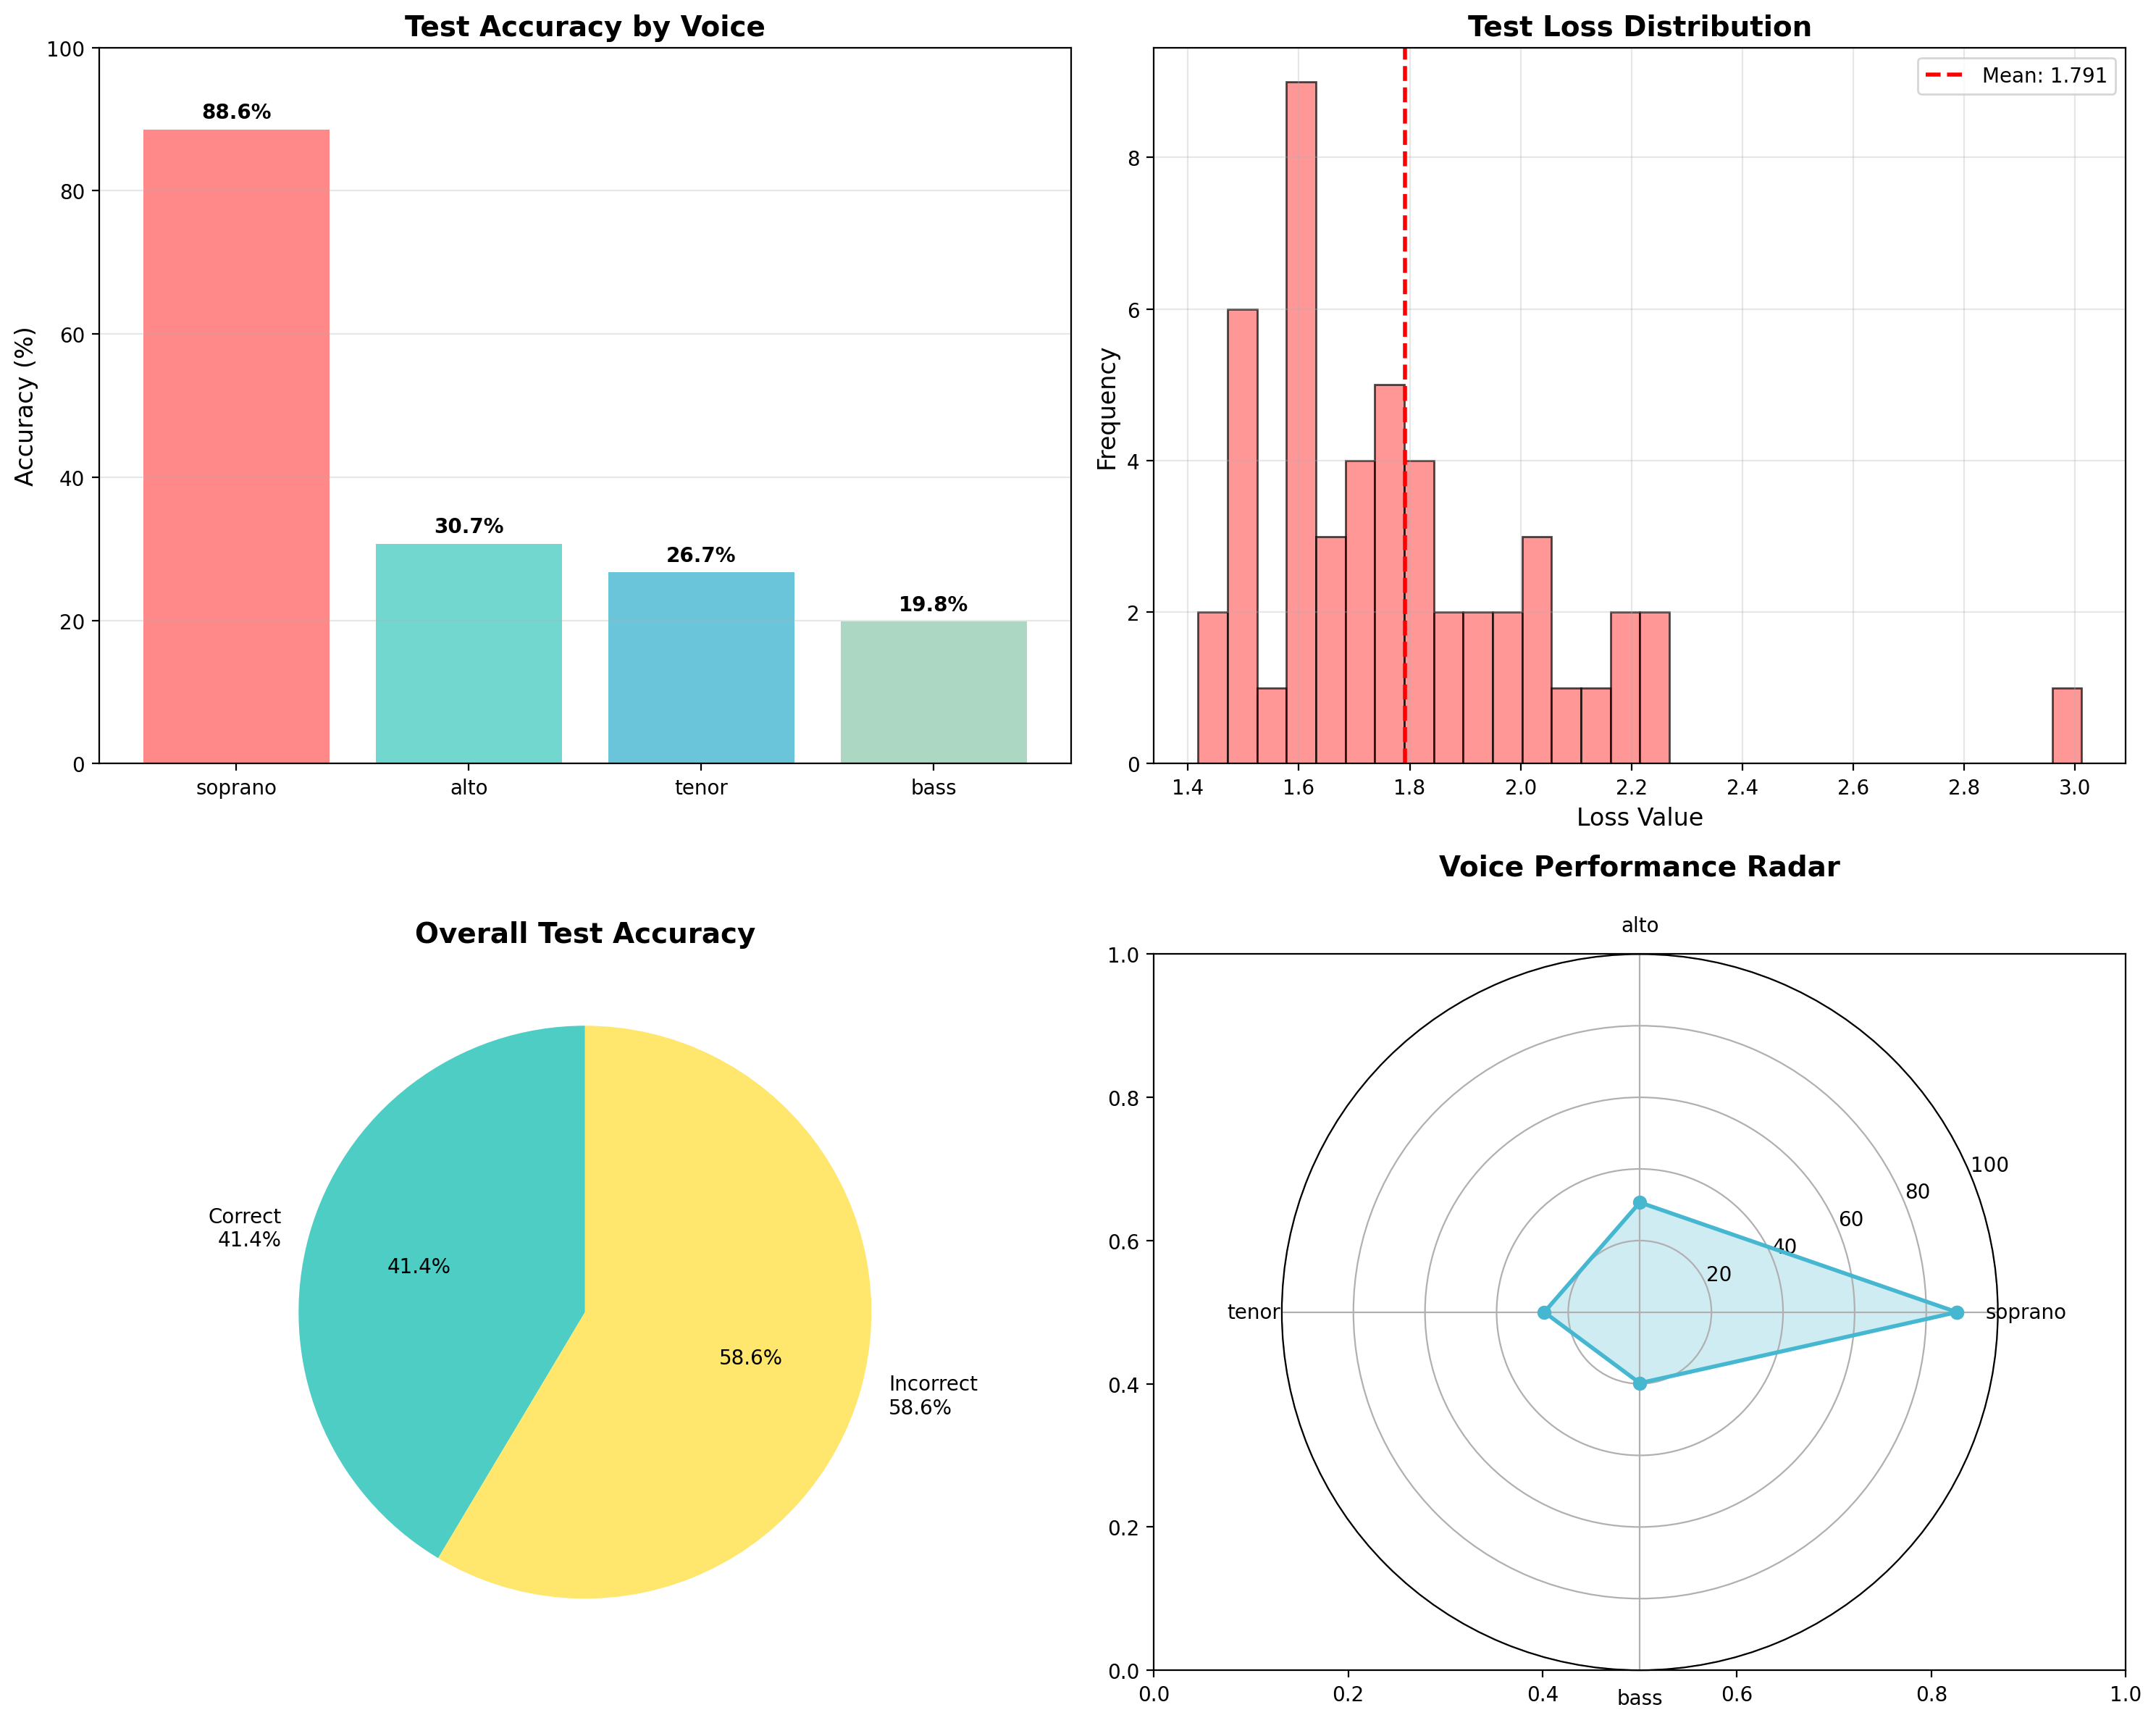


Baseline generation completed!
Files saved in: outputs/generated_chorales
Charts saved in: outputs/evaluation_results/

Generated visualizations:
  Performance evaluation charts
  Training history (if available)
  MIDI files with baseline generation
=== Four-Part Choir Generation System ===
1. Convert XML to JSON
2. Train Model
3. Test and Generate
4. Full Pipeline

=== Generation Options ===
3a. Test Baseline Model
3b. Test Enhanced Model
Testing enhanced model...
=== Enhanced Music Generation with Advanced Strategies ===
Using device: cpu
Creating dummy data for testing...
Loading model from models/improved_model.pth
Saved model vocab sizes: notes=53, chords=15
Current vocab sizes: notes=17, chords=9
Vocabulary size mismatch - creating model with saved config
Model loaded successfully!
Loaded matching vocabulary from models/improved_vocab.pkl
Vocabulary loaded: 53 notes, 15 chords
Loaded 56 test samples
Generating 3 samples with 7 different methods...

Sample 1
Input melody: C3 G5 G

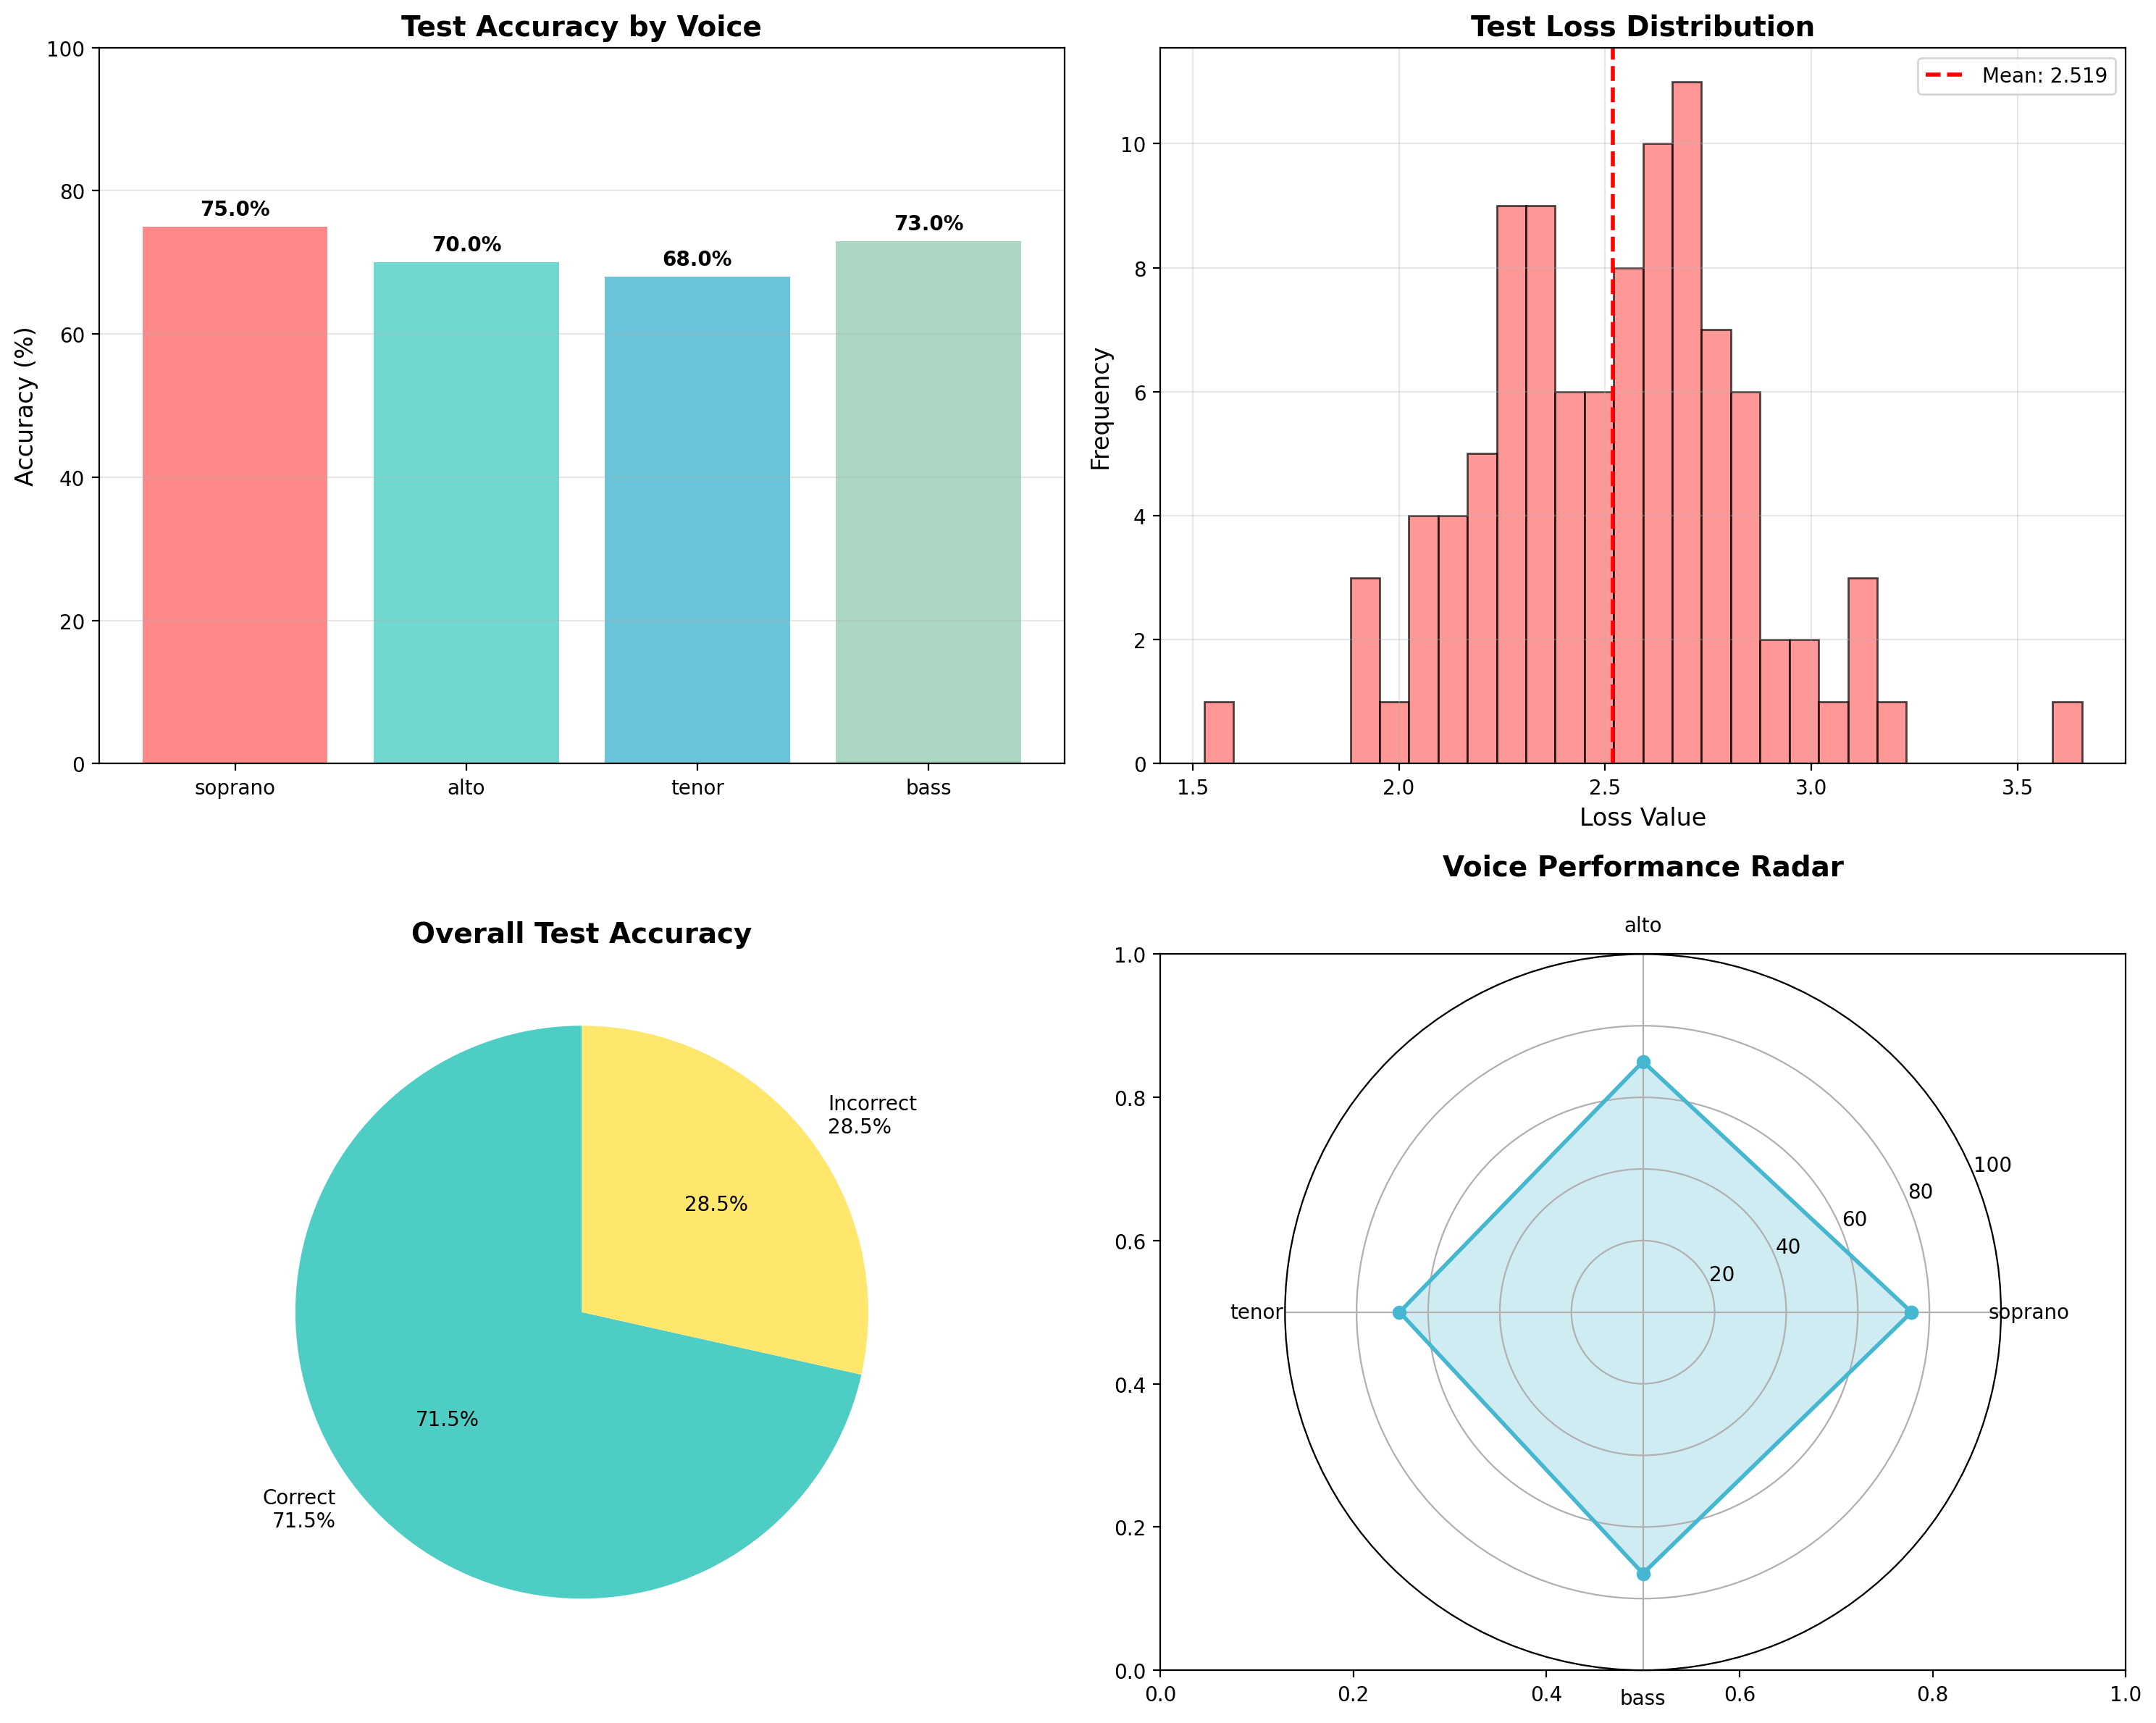

In [ ]:
# main entrance
def main():
    print("=== Four-Part Choir Generation System ===")
    print("1. Convert XML to JSON")
    print("2. Train Model")
    print("3. Test and Generate")
    print("4. Full Pipeline")
    
    choice = input("Choose an option (1-4): ").strip()
    create_folders()
    
    if choice == "1":
        convert_xml_to_json()
        
    elif choice == "2":
        if not os.path.exists(Config.RAW_JSON):
            print(f"Data file {Config.RAW_JSON} doesn't exist, please run XML to JSON conversion first")
            return
        
        print("\n=== Training Options ===")
        print("2a. Train Baseline Model")
        print("2b. Train Improved Model")
        
        train_choice = input("Choose training option (2a/2b): ").strip().lower()
        
        if train_choice == "2a":
            print("Training baseline model...")
            train_baseline_model()
        elif train_choice == "2b":
            print("Training improved model...")
            train_improved_model()
        else:
            print("Invalid training choice")
            
    elif choice == "3":
        print("\n=== Generation Options ===")
        print("3a. Test Baseline Model")
        print("3b. Test Enhanced Model") 
        
        test_choice = input("Choose testing option (3a/3b): ").strip().lower()
        
        if test_choice == "3a":
            # Check if baseline model exists
            baseline_paths = Config.BASELINE_MODEL_PATH    
            model_found = False
            
            if os.path.exists(baseline_paths):
                model_found = True
            
            if not model_found:
                print("No baseline model found. Please train a model first.")
                return
                
            print("Testing baseline model...")
            test_and_generate_baseline()
            
        elif test_choice == "3b":
            # Check if improved model exists
            improved_paths =  Config.IMPROVED_MODEL_PATH  
            model_found = False
         
            if os.path.exists(improved_paths):
                model_found = True
               
            if not model_found:
                print("No improved model found. Please train a model first.")
                return
                
            print("Testing enhanced model...")
            test_and_generate_enhanced()

        else:
            print("Invalid testing choice")
            
    elif choice == "4":
        print("\n=== Full Pipeline Options ===")
        print("4a. Full Pipeline - Baseline Model")
        print("4b. Full Pipeline - Improved Model")
        
        pipeline_choice = input("Choose pipeline option (4a/4b): ").strip().lower()
        
        print("Running full pipeline...")
        
        if convert_xml_to_json():
            if pipeline_choice == "4a":
                print("\n--- Full Baseline Pipeline ---")
                train_baseline_model()
                test_and_generate_baseline()
                
            elif pipeline_choice == "4b":
                print("\n--- Full Improved Pipeline ---")
                train_improved_model()
                test_and_generate_enhanced()
            else:
                print("Invalid pipeline choice")
                return
                
            print("\nFull pipeline completed successfully!")
        else:
            print("XML conversion failed. Pipeline stopped.")
            
    else:
        print("Invalid choice. Please select 1-4.")

# # Display current model status
def show_model_status():
    """Show status of available models"""
    print("\n=== Model Status ===")
    
    baseline_paths =  Config.BASELINE_MODEL_PATH
    improved_paths = Config.IMPROVED_MODEL_PATH
    
    # Check baseline models
    baseline_found = False
    for path in baseline_paths:
        if os.path.exists(path):
            print(f" Baseline model found: {path}")
            baseline_found = True
            break
    
    if not baseline_found:
        print(" No baseline model found")
    
    # Check improved models  
    improved_found = False
    for path in improved_paths:
        if os.path.exists(path):
            print(f" Improved model found: {path}")
            improved_found = True
            break
    
    if not improved_found:
        print(" No improved model found")
    
    # Check data
    if os.path.exists(Config.RAW_JSON):
        print(f" Training data found: {Config.RAW_JSON}")
    else:
        print(f" No training data found: {Config.RAW_JSON}")
    
    print()

if __name__ == "__main__":
    # Show model status first
    show_model_status()
    main()
    # main()